# `RANDOM FOREST`

In [38]:
import sys
from pathlib import Path
import joblib
ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.data_loader import (
    load_splits
)
import time
import numpy as np
import pandas as pd

from sklearn.model_selection import  StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


FIGURES_DIR = ROOT / "reports" / "figures"

In [4]:
# Загружаю сплиты данных
data = load_splits(scaled=False,encoded_y=True)
X_train, X_test, y_train, y_test = data['X_train'], data['X_test'], data['y_train'], data['y_test']

### Обучаем Random Forest на исходных признаках исользуя GreadSercCV

In [5]:
# Модель 
rf = RandomForestClassifier(random_state=42,n_jobs=-1)

# Кросс-валидация
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

# Гиперпараметры
param_grid = {
    'n_estimators': [150,300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True],
    'class_weight': [None]

    
}

# GridSearchCV

gs = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    refit=True,
    
)

# Тренировка 
t0 = time.perf_counter()
gs.fit(X_train,y_train)
total_search_time = time.perf_counter() - t0


In [8]:
# Извлекаю и сохраняю лучшую модель
random_forest = gs.best_estimator_

ARTIFACTS_DIR = Path("../models").resolve()

joblib.dump(random_forest, ARTIFACTS_DIR / "random_forest.pkl")

['C:\\Users\\AlexK\\OneDrive\\Рабочий стол\\Классификаци типов личности\\models\\random_forest.pkl']

In [16]:
best_params = gs.best_params_
fit_time = gs.refit_time_

In [ ]:
# Строю предсказание
y_pred = random_forest.predict(X_test)

In [ ]:
# Оцениваю модель

accuracy =  accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
report = classification_report(y_test, y_pred)


In [ ]:
# Cмотрим важные признаки
feature_importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": random_forest.feature_importances_
}).sort_values(by="importance", ascending=False)

### Топ-10 Признаков для модели
| feature | importance |
|---|---:|
| party_liking | 0.185726 |
| alone_time_preference | 0.105521 |
| public_speaking_comfort | 0.103748 |
| excitement_seeking | 0.101939 |
| talkativeness | 0.099206 |
| social_energy | 0.082244 |
| leadership | 0.043847 |
| adventurousness | 0.043171 |
| group_comfort | 0.040123 |
| reading_habit | 0.035992 |

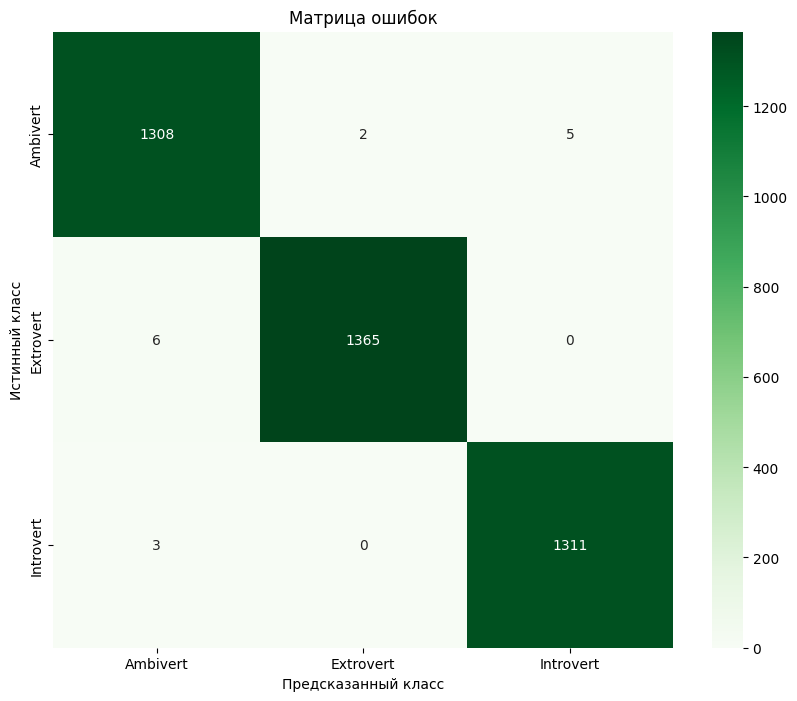

In [39]:
# Строим матрицу ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=["Ambivert", "Extrovert", "Introvert"], yticklabels=["Ambivert", "Extrovert", "Introvert"])
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Матрица ошибок")
plt.savefig(FIGURES_DIR / "RandomForest_Confusion_matrix", dpi=300, bbox_inches='tight')
plt.show()

## 📌 RandomForestClassifier — результаты

### ⚙️ Гиперпараметры
| parameter | value |
|---|---|
| bootstrap | True |
| class_weight | None |
| max_depth | None |
| min_samples_leaf | 1 |
| min_samples_split | 5 |
| n_estimators | 300 |

### ⏱️ Время обучения
| metric | value |
|---|---:|
| training_time_sec | 2.14 |

---

### 📊 Метрики на TEST выборке
| metric | value |
|---|---:|
| accuracy | 0.99 |
| f1_macro | 0.99 |

---

### 🧾 Classification Report
| class | precision | recall | f1-score | support |
|---:|---:|---:|---:|---:|
| Ambivert | 0.99 | 0.99 | 0.99 | 1315 |
| Extrovert | 1.00 | 1.00 | 1.00 | 1371 |
| Introvert | 1.00 | 1.00 | 1.00 | 1314 |
| **accuracy** |  |  | **1.00** | **4000** |
| **macro avg** | **1.00** | **1.00** | **1.00** | **4000** |
| **weighted avg** | **1.00** | **1.00** | **1.00** | **4000** |


### Модель демонстрирует 16 неправильных предсказаний из 4000; ошибки редки и в основном между Ambivert ↔ (Extrovert/Introvert).
